# RandomForest and GradientBoosting Regression
---

In this notebook, regression models are built for predicting apartment rent in NYC.

First, DataFrame containing features such as location, number of bedrooms and bathrooms, and amenities are read from a file. The samples are split into train and test dataset, and regression models are optimized using cross-validation.

Then the performance of two regression models, RandomForest and GradientBoosting, are compared.

## Import libraries and data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
%matplotlib inline

In [3]:
# set style sheet
plt.style.use("ggplot")
sns.set_style("whitegrid")
#sns.set_style("white")

In [4]:
# import cleaned dataset
df = pd.read_csv("data/ny_rental_data_cleaned.r2.csv", index_col=0)

## Data Preprocessing
Features and target are read from the DataFrame, and the dataset is split into train and test datasets. 

The features are standardized ($x\rightarrow \frac{x - \bar{x}}{\sigma}$) using Scikit StandardScaler. It is important to note that when we standardize the features, we need to use the statistics from the train dataset and apply them to both train and test datasets in order prevent information leak from the test dataset to the train dataset. 

In [5]:
# read features from DataFrame
df_base = df[["longitude","latitude","bathrooms","bedrooms","leaseLength","rating","sqft","pet_cat","pet_dog","built_year","property_size"]]
df_extra = df.filter(regex="amenity")

# define features and target
X = pd.concat([df_base, df_extra], axis=1)
y = df["rent"]

In [6]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [7]:
from sklearn import preprocessing
scaler = preprocessing.StandardScaler().fit(X_train)

# standardize features
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

## Grid Search
Grid search is performed to find the optimum set of parameters for RandomForest and GradientBoosting regressors. Cross-validation is used to evaluate the performance given a set of parameters, and the parameters that gives the best $R^{2}$ score is chosen.

However, often GridSearch results in over-fitting, and the parameters are further adjusted to avoid over-fitting the training samples. For this purpose, two flags are implemented to specify wheather GridSearch is performed for RandomForest and GradientBoosting regressor.

In [8]:
# flag for grid search. Set True to perform grid search
GridSearch_RF = False
GridSearch_GB = False

# cross-validation fold
n_cross_validation = 10

In [9]:
# initialize RandomForest and GradientBoosting estimators
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
model_RF = RandomForestRegressor()
model_GB = GradientBoostingRegressor()

# dictionary to hold parameters for each estimator
params_RF = {}
params_GB = {}

In [10]:
# perform GridSearch for RandomForest
if GridSearch_RF:
        param_grid =    {
                        'n_estimators':[5,100,500,1000], 'max_features': ['auto'],
                        'max_depth': [3,5,7],
                        'min_samples_leaf': [1,2],
                        'random_state': [0,1,2,3,4,5]
                        }

        # initiate grid search
        from sklearn.model_selection import GridSearchCV
        grid_search = GridSearchCV( estimator=model, param_grid=param_grid,
                                    cv=n_cross_validation, n_jobs=-1)

        # fit grid search
        grid_search.fit(X_train, y_train)

        # best parameters found by GridSearch
        params_RF = grid_search.best_params_
        print(grid_search.best_params_)

In [11]:
# perform GridSearch for GradientBoosting
if GridSearch_GB:
        param_grid =    {
                        'n_estimators':[100,300],
                        'learning_rate':[0.08, 0.1, 0.12],
                        'max_depth': [2,5,8],
                        'min_samples_leaf': [1,2],
                        'subsample': [0.5,0.8,1],
                        'random_state': [0,1,2,3]
                        }

        # initiate grid search
        from sklearn.model_selection import GridSearchCV
        grid_search = GridSearchCV( estimator=model, param_grid=param_grid,
                                    cv=n_cross_validation, n_jobs=-1)

        # fit grid search
        grid_search.fit(X_train, y_train)

        # best parameters found by GridSearch
        params_GB = grid_search.best_params_
        print(grid_search.best_params_)

If GridSearch is not performed, defaults sets of parameters are used for the estimators.

In [12]:
# if not performing GridSearch, use these parameters
if(params_RF == {}):
        params_RF = {'max_depth': 5, 'max_features': 'auto', 'min_samples_leaf': 3, 'n_estimators': 300, 'random_state': 1}
if(params_GB == {}):
        params_GB = {'learning_rate': 0.015, 'max_depth': 3, 'min_samples_leaf': 4, 'n_estimators': 400, 'random_state': 0, 'subsample': 0.3}

# set parameters obtained from GridSearch
model_RF.set_params(**params_RF)
model_GB.set_params(**params_GB)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.015, loss='ls', max_depth=3,
             max_features=None, max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=4, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=400,
             presort='auto', random_state=0, subsample=0.3, verbose=0,
             warm_start=False)

## Learning Curve
In order to evaluate the regression models with the given hyperparemteres, learning curves are produced by plotting training score and test score at varying sample sizes. Cross-validation is used for evaluating training and test scores, and $R^{2}$ score (1 - SSR/SST) is used for evaluation.

In [13]:
from sklearn.model_selection import learning_curve

# set learning curve step
learning_step = np.linspace(0.1,1.0,20)

# get train size and scores from learning_curve
train_sizes_RF, train_scores_RF, test_scores_RF = learning_curve(
        model_RF, X_train, y_train, cv=n_cross_validation, n_jobs=-1,
        train_sizes=learning_step, random_state=0)
train_sizes_GB, train_scores_GB, test_scores_GB = learning_curve(
        model_GB, X_train, y_train, cv=n_cross_validation, n_jobs=-1,
        train_sizes=learning_step, random_state=0)

In [14]:
# get mean and standard dividation of scores for RandomForest
train_scores_RF_mean = np.mean(train_scores_RF, axis=1)
train_scores_RF_std = np.std(train_scores_RF, axis=1)
test_scores_RF_mean = np.mean(test_scores_RF, axis=1)
test_scores_RF_std = np.std(test_scores_RF, axis=1)

# get mean and standard dividation of scores for GradientBoosting
train_scores_GB_mean = np.mean(train_scores_GB, axis=1)
train_scores_GB_std = np.std(train_scores_GB, axis=1)
test_scores_GB_mean = np.mean(test_scores_GB, axis=1)
test_scores_GB_std = np.std(test_scores_GB, axis=1)

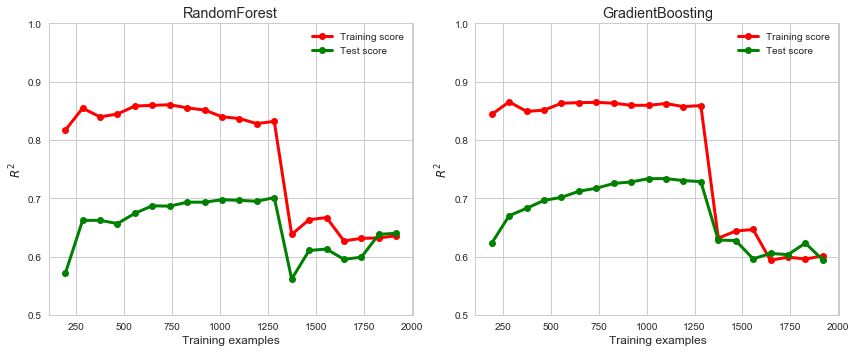

In [15]:
# create axes
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,5))

# plot learning curve for RandomForest
ax1.plot(train_sizes_RF, train_scores_RF_mean, color="r", marker="o", linewidth=3, label="Training score")
ax1.plot(train_sizes_RF, test_scores_RF_mean, color="g", marker="o", linewidth=3, label="Test score")

# plot learning curve for GrandientBoosting
ax2.plot(train_sizes_GB, train_scores_GB_mean, color="r", marker="o", linewidth=3, label="Training score")
ax2.plot(train_sizes_GB, test_scores_GB_mean, color="g", marker="o", linewidth=3, label="Test score")

# customize plots
for ax in (ax1, ax2):
    ax.legend()
    ax.set_ylim([0.5,1])
    ax.set_ylabel("$R^{2}$")
    ax.set_xlabel("Training examples")
    
ax1.set_title("RandomForest")
ax2.set_title("GradientBoosting")

# save figure
plt.tight_layout()

In both RandomForest and GradientBoosting, the learning curves shows that training score and testing score become more close as the sample size increases, indicating that both regressors are not over-fitting data. However, relatively low $R^{2}$ scores suggest that the toal variation in data is not fully explained by either of these models.

Also, due to the limited statistic, it is difficult to determine if more data would be helpful in building better estimator.
- if training and test score improve at larger samples size, we need to collect more data for better regression model.
- if training and test score don't improve at larger sample size, we need more complex model. i.e. adding more features.

## Cross-validated metrics
In addition to learning curves, the performance of estimators are evaluated using cross-validated metrics such as 'negative mean squared error' and $R^{2}$ score. The scores are calculated for RandomForest and GradientBoosting regressors using 10-fold cross-validation.

In [16]:
from sklearn.model_selection import cross_validate

# define scoring method
scoring = ["neg_mean_squared_error", "r2"]

# obtain cross-validated scores
scores_RF = cross_validate(model_RF, X_train, y_train, cv=n_cross_validation, scoring=scoring, return_train_score=True)
scores_GB = cross_validate(model_GB, X_train, y_train, cv=n_cross_validation, scoring=scoring, return_train_score=True)

#### RandomForest cross-validated scores

In [17]:
# cross-validated mean squared error
print("(train) negative mean squared error = %0.3f (+/- %0.3f)" % (scores_RF["train_neg_mean_squared_error"].mean(), scores_RF["train_neg_mean_squared_error"].std()*100))
print("(validation) negative mean squared error = %0.3f (+/- %0.3f)" % (scores_RF["test_neg_mean_squared_error"].mean(), scores_RF["test_neg_mean_squared_error"].std()*100))

# cross-validated R2
print("(train) R2 score = %0.3f (+/- %0.3f)" % (scores_RF["train_r2"].mean(), scores_RF["train_r2"].std()*100))
print("(validation) R2 score = %0.3f (+/- %0.3f)" % (scores_RF["test_r2"].mean(), scores_RF["test_r2"].std()*100))

(train) negative mean squared error = -1809887.691 (+/- 44710307.962)
(validation) negative mean squared error = -2859499.446 (+/- 618307765.210)
(train) R2 score = 0.635 (+/- 6.144)
(validation) R2 score = 0.640 (+/- 18.930)


#### GradientBoosting cross-validated scores

In [18]:
# cross-validated mean squared error
print("(train) negative mean squared error = %0.3f (+/- %0.3f)" % (scores_GB["train_neg_mean_squared_error"].mean(), scores_GB["train_neg_mean_squared_error"].std()*100))
print("(validation) negative mean squared error = %0.3f (+/- %0.3f)" % (scores_GB["test_neg_mean_squared_error"].mean(), scores_GB["test_neg_mean_squared_error"].std()*100))

# cross-validated R2
print("(train) R2 score = %0.3f (+/- %0.3f)" % (scores_GB["train_r2"].mean(), scores_GB["train_r2"].std()*100))
print("(validation) R2 score = %0.3f (+/- %0.3f)" % (scores_GB["test_r2"].mean(), scores_GB["test_r2"].std()*100))

(train) negative mean squared error = -1998125.493 (+/- 54105804.087)
(validation) negative mean squared error = -2916320.856 (+/- 585746005.146)
(train) R2 score = 0.600 (+/- 8.496)
(validation) R2 score = 0.596 (+/- 18.821)


## Fitting models and making prediction
In the previous section, the hyperparameters for RandomForest and GradientBoosting are chosen by learning curves and cross-validated scores. Now, the models are trained using the training dataset, and predictions are made on training and test datasets.

After making predictions, $R^{2}$ and mean absolute percentage errors are evaluated for both training and test samples.

In [19]:
# fit train dataset
model_RF.fit(X_train,y_train)
model_GB.fit(X_train,y_train)

# make prediction on train/test dataset using RandomForest
y_pred_train_RF = model_RF.predict(X_train)
y_pred_test_RF = model_RF.predict(X_test)

# make prediction on train/test dataset using GradientBoosting
y_pred_train_GB = model_GB.predict(X_train)
y_pred_test_GB = model_GB.predict(X_test)

In [20]:
from sklearn import metrics

# function to calculate mean percentage error
def mean_absolute_percentage_error(y_true, y_prediction):
    # create np array from list
    y_true, y_prediction = np.array(y_true), np.array(y_prediction)

    # return mean absolute percentage error
    return np.mean(np.abs((y_true - y_prediction) / y_true))

#### RandomForest scores

In [21]:
# train errors using RandomForest
print("(train) R2 score = %0.3f" % model_RF.score(X_train, y_train))
print("(train) mean absolute percentage error = %0.3f" %mean_absolute_percentage_error(y_train, y_pred_train_RF))

# test errors using RandomForest
print("(test) R2 score = %0.3f" % model_RF.score(X_test, y_test))
print("(test) mean absolute percentage error = %0.3f" %mean_absolute_percentage_error(y_test, y_pred_test_RF))

(train) R2 score = 0.616
(train) mean absolute percentage error = 0.156
(test) R2 score = 0.674
(test) mean absolute percentage error = 0.168


#### GradientBoosting scores

In [22]:
# train errors using GradientBoosting
print("(train) R2 score = %0.3f" % model_GB.score(X_train, y_train))
print("(train) mean absolute percentage error = %0.3f" %mean_absolute_percentage_error(y_train, y_pred_train_GB))

# test errors using GradientBoosting
print("(test) R2 score = %0.3f" % model_GB.score(X_test, y_test))
print("(test) mean absolute percentage error = %0.3f" %mean_absolute_percentage_error(y_test, y_pred_test_GB))

(train) R2 score = 0.572
(train) mean absolute percentage error = 0.148
(test) R2 score = 0.762
(test) mean absolute percentage error = 0.154


## Scatter Plot: Prediction vs Observed
In order to visualize how well the predictions from the regression models agree with observed value, the predictions are plotted against true values. The scatter plots show good linearity between predicted value and true value. GradientBoosting seems to provide better prediction, especially in the range between \$5,000 and \$7,500.

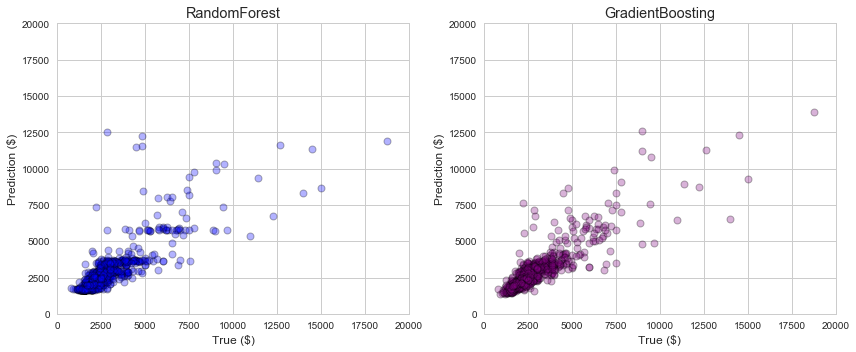

In [23]:
# make scatter plot
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(12,5))

# scatter plot of prediction vs test samples
sns.regplot(y_test, y_pred_test_RF, color="b", marker="o", ax=ax1, fit_reg=False,
            scatter_kws={'alpha':0.3, 'edgecolors':"black", 'linewidths':1})
sns.regplot(y_test, y_pred_test_GB, color="purple", marker="o", ax=ax2, fit_reg=False,
            scatter_kws={'alpha':0.3, 'edgecolors':"black", 'linewidths':1})

# customize plots
for ax in (ax1, ax2):
    ax.set_xlim([0,20000])
    ax.set_ylim([0,20000])
    ax.set_ylabel("Prediction ($)")
    ax.set_xlabel("True ($)")

ax1.set_title("RandomForest")
ax2.set_title("GradientBoosting")

plt.tight_layout()

## Histogram: Percentage Residual
The percentage residual of the prediction models are plotted with histograms. The percentage residual is defined by

Percentage residual = $(\hat{y_{i}} - y_{i}) / y_{i}$ where $\hat{y}$ represent predicted value.

The distributions of both RandomForest and GradientBoosting have mean of $\approx$ -0.05, suggesting that the models are slightly over-estimating rent. The standard deviation is slightly larger for the RandomForest method, but further test is needed to determine if two distributions are statistically different.

In [24]:
# function to calculate percentage error
def percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return (y_true - y_pred) / y_true

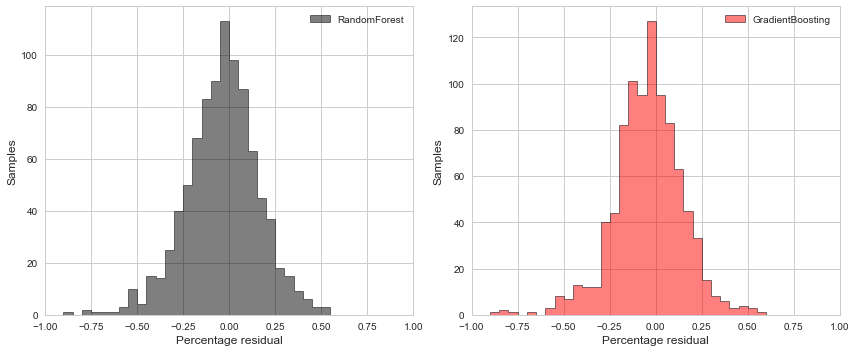

In [25]:
from scipy import stats

# create figure and axes
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(12,5))

# distribution of percentage error
sns.distplot(   percentage_error(y_test, y_pred_test_RF), kde=False,
                bins=100, ax=ax1, hist=True, 
                hist_kws={"alpha":0.5, "color":"black", "linewidth":1,
                "edgecolor":"black", "range":(-2.5,2.5), "histtype":"stepfilled"},
                label="RandomForest")
sns.distplot(   percentage_error(y_test, y_pred_test_GB), kde=False,
                bins=100, ax=ax2, hist=True,
                hist_kws={"alpha":0.5, "color":"r", "linewidth":1,
                "edgecolor":"black", "range":(-2.5,2.5), "histtype":"stepfilled"},
                label="GradientBoosting")

# customize plots
for ax in (ax1,ax2):
    ax.set_ylabel("Samples")
    ax.set_xlabel("Percentage residual")
    ax.set_xlim([-1.0,1.0])
    ax.legend()

plt.tight_layout()

In [26]:
print("mean percentage residual = " + str(np.array(percentage_error(y_test, y_pred_test_RF)).mean()))
print("mean percentage residual = " + str(np.array(percentage_error(y_test, y_pred_test_GB)).mean()))

print("std percentage residual = " + str(np.array(percentage_error(y_test, y_pred_test_RF)).std()))
print("std percentage residual = " + str(np.array(percentage_error(y_test, y_pred_test_GB)).std()))

mean percentage residual = -0.0556839454032
mean percentage residual = -0.054551739349
std percentage residual = 0.26336286057
std percentage residual = 0.224177312376


## Scatter Plot: Residual vs Observed
Residuals, defined by predicted value - true value ($\hat{y} - y$), are plotted against observed $y$ for both RandomForest and GradientBoosting. Residuals from training sample and test sample are plotted separately.

- The residual distribution of RandomForest regression shows non-random, artificial structure, suggesting that the model isn't describing data very well.
- The residual distribution of GradientBoosting is slightly skewed, but we don't see artificial structure as in the RandomForest residual distribution. This also makes sense because from the percentage residual plots, we have learned that both models are slightly over-estimating the data (~5%).

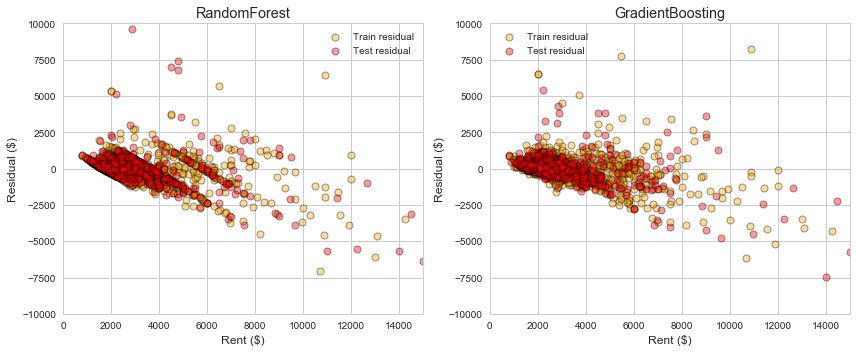

In [27]:
# create figure and axes
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(12,5))

# make residual plot for RandomForest
sns.regplot(y_train, y_pred_train_RF - y_train,
            color="orange", marker="o", ax=ax1, fit_reg=False, label="Train residual",
            scatter_kws={'alpha':0.4, 'edgecolors':"black", 'linewidths':1})
sns.regplot(y_test, y_pred_test_RF - y_test,
            color="r", marker="o",  ax=ax1, fit_reg=False, label="Test residual",
            scatter_kws={'alpha':0.4, 'edgecolors':"black", 'linewidths':1})
# make residual plot for GradientBoosting
sns.regplot(y_train, y_pred_train_GB - y_train,
            color="orange", marker="o", ax=ax2, fit_reg=False, label="Train residual",
            scatter_kws={'alpha':0.4, 'edgecolors':"black", 'linewidths':1})
sns.regplot(y_test, y_pred_test_GB - y_test,
            color="r", marker="o",  ax=ax2, fit_reg=False, label="Test residual",
            scatter_kws={'alpha':0.4, 'edgecolors':"black", 'linewidths':1})

# customize plot
for ax in (ax1, ax2):
    ax.set_ylabel("Residual ($)")
    ax.set_xlabel("Rent ($)")
    ax.set_ylim([-1e4,1e4])
    ax.set_xlim([0,1.5e4])
    ax.legend()
    
ax1.set_title("RandomForest")
ax2.set_title("GradientBoosting")

plt.tight_layout()
plt.legend()

## Important Features
The features that contributed the most in building the regression models are obtained by feature\_importances\_ method. Since there are more than 80 features considered in this analysis, only 10 most important features are plotted.

In RandomForest regression model, top five features dominated in building the model. In GradientBoosting regression model, more features contributed to the model, but 'number of bathrooms' made the most significant contribution to the model.

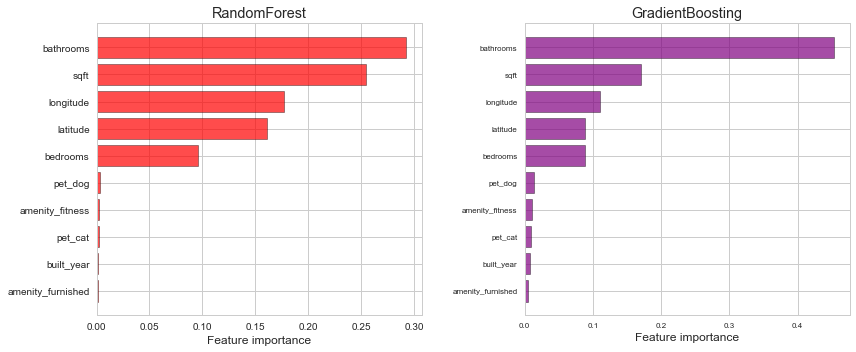

In [28]:
# create figure and axes
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(12,5))

# get feature name and feature importance
feature_name = X.columns.values
feature_importance_RF = model_RF.feature_importances_
feature_importance_GB = model_GB.feature_importances_

# pick top features
n_features = 10
top_features_RF = sorted(   zip(feature_name, feature_importance_RF),
                            key=lambda x:x[1], reverse=True)[:n_features]
top_features_GB = sorted(   zip(feature_name, feature_importance_GB),
                            key=lambda x:x[1], reverse=True)[:n_features]

# make horizontal bar plot
ax1.barh(np.arange(n_features), [x[1] for x in top_features_RF], color="r", alpha=0.7, edgecolor="black")
ax2.barh(np.arange(n_features), [x[1] for x in top_features_GB], color="purple", alpha=0.7, edgecolor="black")

# customize plots
for ax in (ax1, ax2):
    ax.set_yticks(np.arange(n_features))
    ax.set_yticklabels([x[0] for x in top_features_RF])
    ax.invert_yaxis()
    ax.set_xlabel("Feature importance")
    
ax1.set_title("RandomForest")
ax2.set_title("GradientBoosting")

plt.tight_layout()
plt.tick_params(axis='both', which='major', labelsize=8)

## Conclusion
In this notebook, two regression models, RandomForest and GradientBoosting, are compared. Although two models provided a similar performance by $R^{2}$ score and percentage residual distribution, GradientBoosting seems to provide more reliable prediction of data because in GradientBoosting,
- Prediction vs Observed scatter plot seems to be more linear.
- Percentage residual has narrower distribution (smaller $\sigma$).
- Residual vs Observed scatter plot shows more natural, randomness.
- Relative to RandomForest, more features contributed to the model.

However, the prediction made by the GradientBoosting regression model is still limited for the following reasons.
- $R^{2} \approx $ 60%  suggests that not all variance in data can be explained by these models.
- The large standard deviation in percentage residual ($\sigma \approx$ 0.22) suggests that the prediction will be off by more than 22% with probability of ~30%.